## Compute geometric information

ggPIV and bbPIV are cell arrays of the first and second fundamental form evaluated at the PIV coordinate locations in a resized image (0.4 * original pixel dimensions) when compared to the embedding space of the embryo surface. The ith cell is the fundamental form of [X0(i), Y0(i)] evaluation point -- note that X0 and Y0 are unravelled for this indexing. \nX0 and Y0 are the resized image pixel positions of the PIV evaluation points. \ngg and bb are the first and second fundamental forms for each face of rect_embryo_noglue.ply compared to the pullback rect_PIVImageScale.ply
Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Metric at (0, 0)
 [[ 0.144  0.   ]
 [ 0.    30.005]]
Inverse metric at (0, 0)
 [[6.96  0.   ]
 [0.    0.033]]
Christoffel Symbol Shape:  (236, 200, 2, 2, 2)


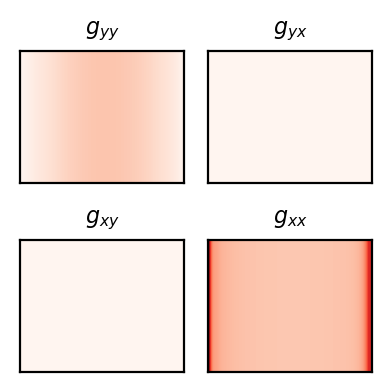

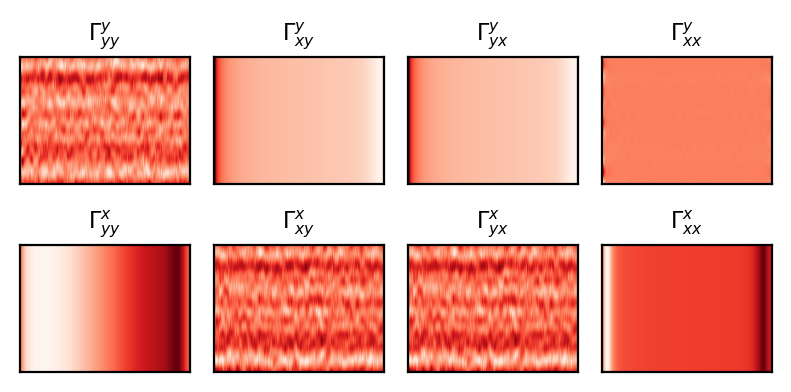

In [6]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

from morphogenesis.plot_utils import plot_scalar

with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)
    
diff_args = dict(
    dAP=dAP,
    dDV=dDV,
    sigma=5, 
)

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

geo_dir = '../flydrive/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
print(geometry['readme'])
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

#Interpolate metric onto evaluation points
gg = geometry['ggPIV']
gg = np.stack([g for g in gg], axis=0)
gg = np.stack([g for g in gg], axis=0).reshape([X0g.shape[0], Y0g.shape[0], 2, 2])
gg = gg.transpose(1, 0, 2, 3)
gg[..., 0, 1] = 0 #Eliminate off-diagonal metric components
gg[..., 1, 0] = 0 #Eliminate off-diagonal metric components
gg = np.broadcast_to(gg.mean(axis=0, keepdims=True), gg.shape) #Remove DV variation
gg = gg[..., ::-1, ::-1] #Swap y, x coordinates

gij = []
gg = gg.reshape([*gg.shape[:2], 4])
for i in range(gg.shape[-1]):
    gij.append(RectBivariateSpline(Y0g, X0g, gg[..., i])(dv, ap))
gij = np.stack(gij, axis=-1).reshape([dv.shape[0], ap.shape[0], 2, 2])
ginv = np.linalg.inv(gij)

#Print out metric information as a check
np.set_printoptions(precision=3, suppress=True)
print('Metric at (0, 0)\n', gij[0, 0])
print('Inverse metric at (0, 0)\n', ginv[0, 0])

#Build Christoffel symbols
gij_k = gradient(gij.transpose(2, 3, 0, 1), **diff_args)
gij_k = gij_k.transpose(2, 3, 0, 1, 4)

Gijk =  0.5 * (
    np.einsum('yxil,yxjlk->yxijk', ginv, gij_k) + \
    np.einsum('yxil,yxlkj->yxijk', ginv, gij_k) - \
    np.einsum('yxil,yxjkl->yxijk', ginv, gij_k)
)
print('Christoffel Symbol Shape: ', Gijk.shape)

fig, ax = plt.subplots(2, 2, dpi=200, figsize=(2, 2))
ij = ['y', 'x']
vmin = np.min(gij)
vmax = np.max(gij)
for i in range(2):
    for j in range(2):
        plot_scalar(ax[i, j], gij[..., i, j], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[i, j].set_title('$g_{%s %s}$' % (ij[i], ij[j]))
        ax[i, j].set_aspect('auto')
plt.tight_layout()

fig, ax = plt.subplots(2, 4, dpi=200, figsize=(4, 2))
vmin = np.min(Gijk)
vmax = np.max(Gijk)
for i in range(2):
    for j in range(2):
        for k in range(2):
            plot_scalar(ax[i, 2*k+j], Gijk[..., i, j, k], cmap='Reds')#, vmin=vmin, vmax=vmax)
            ax[i, 2*k+j].set_title('$\\Gamma^{%s}_{%s %s}$' % (ij[i], ij[j], ij[k]))
            ax[i, 2*k+j].set_aspect('auto')
plt.tight_layout()

np.save('../flydrive/embryo_geometry/christoffel_symbols', Gijk)


def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x